In [1]:
import numpy as np  
import pandas as pd  
import cv2
import os 
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
annotation=pd.read_csv("/kaggle/input/blood-cell-detection-dataset/annotations.csv")
annotation.head()

,image,xmin,ymin,xmax,ymax,label
0,image-100.png,0.000000,0.000000,25.190198,40.816803,rbc
1,image-100.png,15.010502,0.000000,68.337223,23.527421,rbc
2,image-100.png,25.017503,16.021004,78.374562,73.735123,rbc
3,image-100.png,75.565928,1.061844,140.248541,45.591599,rbc
4,image-100.png,77.483081,23.290548,131.936989,74.806301,rbc


In [4]:
col_name=[]
col_dtype=[]
unique=[]
nunique=[]
counts=[]
for col in annotation.columns:
    col_name.append(col)
    col_dtype.append(annotation[col].dtype)
    unique.append(annotation[col].unique())
    nunique.append(annotation[col].nunique())
    counts.append(annotation[col].value_counts().to_dict())

Check_Dict={'Column':col_name,'Number of Unique Values':nunique,'Unique Values':unique,'Data Type':col_dtype,"Counts":counts}
Check_Dict=pd.DataFrame(Check_Dict)
Check_Dict

,Column,Number of Unique Values,Unique Values,Data Type,Counts
0,image,100,"[image-100.png, image-101.png, image-102.png, ...",object,"{'image-69.png': 33, 'image-118.png': 33, 'ima..."
1,xmin,2002,"[0.0, 15.010501750291716, 25.017502917152857, ...",float64,"{0.0: 330, 217.52311161217585: 2, 191.59075535..."
2,ymin,2050,"[0.0, 16.02100350058343, 1.0618436406067675, 2...",float64,"{0.0: 281, 172.36753100338217: 2, 211.93010146..."
3,xmax,2066,"[25.1901983663944, 68.3372228704784, 78.374562...",float64,"{256.0: 264, 48.687711386696726: 2, 210.914317..."
4,ymax,2102,"[40.81680280046674, 23.52742123687281, 73.7351...",float64,"{256.0: 228, 245.1758737316798: 2, 239.7948139..."
5,label,2,"[rbc, wbc]",object,"{'rbc': 2237, 'wbc': 103}"


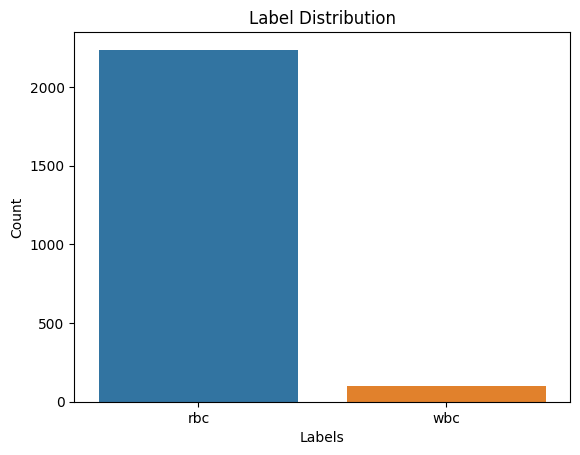

In [5]:
#As we can see, the data isn't balanced, so we need to try augmenting the minority class.
sns.countplot(x=annotation['label'])
plt.xlabel("Labels")
plt.ylabel("Count")
plt.title("Label Distribution")
plt.show()

In [6]:
annotation['label'].value_counts()

label
rbc    2237
wbc     103
Name: count, dtype: int64

### The data is imbalanced, so we need to augment the minority class to improve model performance. One effective approach is to crop the minority cells from the original images and apply various augmentation techniques to them. This is particularly useful since both classes can coexist within the same images.

In [7]:
images = annotation.image.unique().tolist()
np.random.shuffle(images)
train_images = images[:64]
valid_images = images[64:80]
test_images = images[80:]

In [ ]:
len(train_images)

In [8]:
images_path="/kaggle/input/blood-cell-detection-dataset/images/"
prep_path="/kaggle/working/all/"
os.makedirs(prep_path,exist_ok=True)

In [9]:
for img in images:
    image=cv2.imread(images_path+img)
    cv2.imwrite(prep_path+img, image)  

## Getting the Images of the Minority Class

In [10]:
new_images=[]
wbc_rows=[]
new_images=[]

In [11]:
for image_name in train_images:
    labels = annotation[(annotation['image'] == image_name) & (annotation['label'] == 'wbc')].values
    # If the image contains at least one white blood cell annotation and with 30% probability, process it
    if len(labels) > 0 and np.random.rand() < 0.3:
        image = cv2.imread(images_path + image_name)
        x1, y1, x2, y2 = labels[0, 1:5]
        
        # Adjust the bounding box to slightly shrink the area:
        x1, y1 = x1 * 1.05, y1 * 1.05
        x2, y2 = 0.95 * x2, 0.95 * y2
        

        if x2 < x1 or y2 < y1:
            continue  

        c_image = image[int(y1):int(y2), int(x1):int(x2)]
        c_image = cv2.resize(c_image, (256, 256))
        new_labels = labels.copy()
        new_labels[0, 0] = 'w' + new_labels[0, 0]
        # Add the new image name to the list of new images for later processing
        new_images.append(new_labels[0, 0])
        cv2.imwrite(prep_path + new_labels[0, 0], c_image)
        new_labels[0, 1:5] = 0.001, 1.001, 255.999, 255.999
        
        # Append the new label to the list of white blood cell labels for future inclusion IN DATAFRAME
        wbc_rows.append(new_labels[0])

The reason for using values like 0.001, 1.001, 255.999, and 255.999 instead of exactly 0, 0, 256, and 256 is to avoid potential edge-case issues during later processing steps. Here are a few points that explain the rationale:
* **Avoiding Exact Boundaries:**
Using exact 0 or 256 can sometimes lead to numerical or rounding issues when converting coordinates to normalized values. A tiny offset helps prevent problems such as division rounding or boundary-related errors during training or evaluation.

* **Ensuring Non-Degenerate Boxes:**
With slight offsets, the box is almost the entire image—but not exactly—so that when the box is normalized (for example, to compute the center and dimensions for YOLO), it avoids values like exactly 0 or 1. This can be important if the training code has any special handling for extreme normalized values.

In [12]:
print(type(wbc_rows))
print(wbc_rows)
wbc_rows=np.stack(wbc_rows)
print(type(wbc_rows))
print(wbc_rows)

<class 'list'>
[array(['wimage-71.png', 0.001, 1.001, 255.999, 255.999, 'wbc'],
      dtype=object), array(['wimage-113.png', 0.001, 1.001, 255.999, 255.999, 'wbc'],
      dtype=object), array(['wimage-20.png', 0.001, 1.001, 255.999, 255.999, 'wbc'],
      dtype=object), array(['wimage-116.png', 0.001, 1.001, 255.999, 255.999, 'wbc'],
      dtype=object), array(['wimage-112.png', 0.001, 1.001, 255.999, 255.999, 'wbc'],
      dtype=object), array(['wimage-39.png', 0.001, 1.001, 255.999, 255.999, 'wbc'],
      dtype=object), array(['wimage-92.png', 0.001, 1.001, 255.999, 255.999, 'wbc'],
      dtype=object), array(['wimage-104.png', 0.001, 1.001, 255.999, 255.999, 'wbc'],
      dtype=object), array(['wimage-22.png', 0.001, 1.001, 255.999, 255.999, 'wbc'],
      dtype=object), array(['wimage-55.png', 0.001, 1.001, 255.999, 255.999, 'wbc'],
      dtype=object), array(['wimage-28.png', 0.001, 1.001, 255.999, 255.999, 'wbc'],
      dtype=object), array(['wimage-34.png', 0.001, 1.001, 255.999

In [13]:
wbc_df=pd.DataFrame(wbc_rows,columns=annotation.columns)
wbc_df

,image,xmin,ymin,xmax,ymax,label
0,wimage-71.png,0.001,1.001,255.999,255.999,wbc
1,wimage-113.png,0.001,1.001,255.999,255.999,wbc
2,wimage-20.png,0.001,1.001,255.999,255.999,wbc
3,wimage-116.png,0.001,1.001,255.999,255.999,wbc
4,wimage-112.png,0.001,1.001,255.999,255.999,wbc
5,wimage-39.png,0.001,1.001,255.999,255.999,wbc
6,wimage-92.png,0.001,1.001,255.999,255.999,wbc
7,wimage-104.png,0.001,1.001,255.999,255.999,wbc
8,wimage-22.png,0.001,1.001,255.999,255.999,wbc
9,wimage-55.png,0.001,1.001,255.999,255.999,wbc


In [14]:
train_images.extend(new_images)
annotation = pd.concat([annotation , wbc_df],axis=0, ignore_index=True)
annotation.tail()

,image,xmin,ymin,xmax,ymax,label
2362,wimage-50.png,0.001,1.001,255.999,255.999,wbc
2363,wimage-77.png,0.001,1.001,255.999,255.999,wbc
2364,wimage-117.png,0.001,1.001,255.999,255.999,wbc
2365,wimage-94.png,0.001,1.001,255.999,255.999,wbc
2366,wimage-95.png,0.001,1.001,255.999,255.999,wbc


In [38]:
len(annotation)

6825

##  Data Augmentation for Training Images

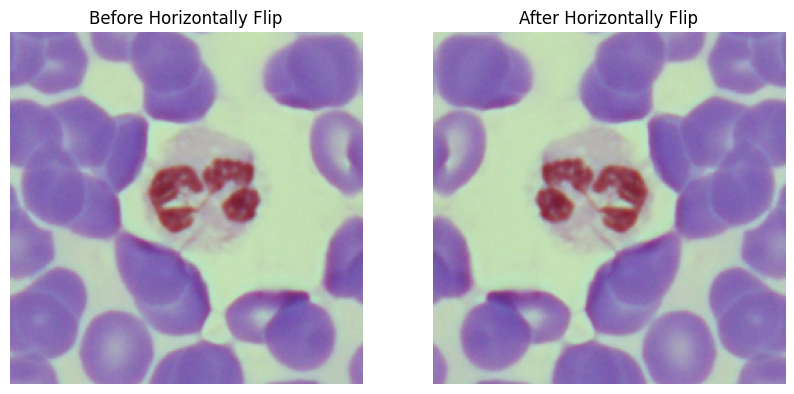

In [15]:
img=cv2.imread((images_path+train_images[0]))
imagefl=np.fliplr(img)
fig,ax=plt.subplots(1,2,figsize=(10,5))

ax[0].imshow(img)
ax[0].set_title("Before Horizontally Flip")
ax[0].axis("off")   

ax[1].imshow(imagefl)
ax[1].set_title("After Horizontally Flip")
ax[1].axis("off")   

plt.show()

- **Horizontal Flip:**  
  - New x-coordinates are computed as `256 - (original x)` while keeping y-coordinates the same.
  - Example: (50, 60, 100, 120) → (156, 60, 206, 120)

- **Vertical Flip:**  
  - New y-coordinates are computed as `256 - (original y)` while keeping x-coordinates the same.
  - Example: (50, 60, 100, 120) → (50, 136, 100, 196)

- **Both Flips:**  
  - Both x and y coordinates are recalculated using the above formulas.
  - Example: (50, 60, 100, 120) → (156, 136, 206, 196)

In [16]:
new_rows=[]
aug_images=[]
# name x1 y1 x2 y2 
for image_name in train_images:
    labels=annotation[annotation['image']==image_name].values
    image= cv2.imread(prep_path+image_name)

    labelsh=labels.copy()
    imagehf=np.fliplr(image)
    labelsh[:,0]='h'+labelsh[:,0]
    aug_images.append(labelsh[0,0])
    cv2.imwrite(prep_path+labelsh[:,0][0],imagehf)
    labelsh[:,[1,3]]= 256-labelsh[:,[3,1]]

    labelsv=labels.copy()    
    imagevf=np.flipud(image)
    labelsv[:,0]='v'+labelsv[:,0]
    aug_images.append(labelsv[0,0])
    cv2.imwrite(prep_path+labelsv[:,0][0],imagevf)
    labelsv[:,[2,4]]=256-labelsv[:,[4,2]]
    

    labelshv=labels.copy()
    imagehvf=np.fliplr(np.flipud(image))
    labelshv[:,0]='hr'+labelshv[:,0]
    aug_images.append(labelshv[0,0])
    cv2.imwrite(prep_path+labelshv[:,0][0],imagehvf)
    labelshv[:,[1,2,3,4]]=256-labelshv[:,[3,4,1,2]]
    

    new_labels=np.vstack((labelsh,labelsv,labelshv))
    new_rows.append(new_labels)

In [ ]:
type(new_rows)
print(new_rows)
new_rows=np.vstack(new_rows)
type(new_rows)
print(new_rows)

In [18]:
train_images.extend(aug_images)
aug_df=pd.DataFrame(new_rows,columns=annotation.columns)
aug_df

,image,xmin,ymin,xmax,ymax,label
0,himage-71.png,71.427283,69.149944,160.149944,160.276212,wbc
1,himage-71.png,230.631342,0.0,256.0,39.554679,rbc
2,himage-71.png,201.137542,0.0,241.028185,45.184893,rbc
3,himage-71.png,165.64938,0.0,197.385569,23.471251,rbc
4,himage-71.png,118.43743,0.0,166.589628,45.169109,rbc
...,...,...,...,...,...,...
4453,vwimage-94.png,0.001,0.001,255.999,254.999,wbc
4454,hrwimage-94.png,0.001,0.001,255.999,254.999,wbc
4455,hwimage-95.png,0.001,1.001,255.999,255.999,wbc
4456,vwimage-95.png,0.001,0.001,255.999,254.999,wbc


In [19]:
annotation=pd.concat([annotation,aug_df],axis=0,ignore_index=True)
annotation

,image,xmin,ymin,xmax,ymax,label
0,image-100.png,0.0,0.0,25.190198,40.816803,rbc
1,image-100.png,15.010502,0.0,68.337223,23.527421,rbc
2,image-100.png,25.017503,16.021004,78.374562,73.735123,rbc
3,image-100.png,75.565928,1.061844,140.248541,45.591599,rbc
4,image-100.png,77.483081,23.290548,131.936989,74.806301,rbc
...,...,...,...,...,...,...
6820,vwimage-94.png,0.001,0.001,255.999,254.999,wbc
6821,hrwimage-94.png,0.001,0.001,255.999,254.999,wbc
6822,hwimage-95.png,0.001,1.001,255.999,255.999,wbc
6823,vwimage-95.png,0.001,0.001,255.999,254.999,wbc


In [20]:
annotation['label'].value_counts()

label
rbc    6413
wbc     412
Name: count, dtype: int64

## Getting TXT Label Files for YOLO

In [ ]:
yolo_images_dir="/kaggle/working/yolo/images"
yolo_labels_dir="/kaggle/working/yolo/labels"

split=["train", "valid", "test"]

for d in [yolo_images_dir,yolo_labels_dir]:
    for s in split:
        path=os.path.join(d,s)
        os.makedirs(path,exist_ok=True)

In [21]:
WIDTH = 256
HEIGHT = 256
cells_id = {
    'rbc': 0,
    'wbc': 1
}

def save_labels(images_set,subfolder):
    for img in images_set:
        lables_file =os.path.join(yolo_labels_dir, subfolder, img.replace(".png", ".txt"))
        with open(lables_file, "w") as lab_file:
            for bbox in annotation[annotation['image']==img].values:
                lab_file.write(f"{cells_id[bbox[5]]} {((bbox[1]+bbox[3])/2.0)/WIDTH} {((bbox[2]+bbox[4])/2.0)/HEIGHT} {(bbox[3]-bbox[1]) / WIDTH} {(bbox[4]-bbox[2]) / HEIGHT}\n")


save_labels(train_images,"train")
save_labels(test_images,"test")
save_labels(valid_images,"valid")

## Getting Images Files for YOLO

In [22]:
def get_images(images_set,subfolder):
    for image in images_set:
        src=os.path.join(prep_path,image)
        dst=os.path.join(yolo_images_dir,subfolder,image)
        img=cv2.imread(src)
        img=cv2.resize(img,(256,256))
        cv2.imwrite(dst,img)


get_images(train_images, 'train')
get_images(valid_images, 'valid')
get_images(test_images, 'test')

In [23]:
yaml_file="""
train: /kaggle/working/yolo/images/train
val: /kaggle/working/yolo/images/valid
test: /kaggle/working/yolo/images/test

#Classes
nc: 2
names: ['rbc', 'wbc']

"""
with open("/kaggle/working/yolo/cell_detection.yaml", "w") as file:
    file.write(yaml_file)

In [24]:
pip install ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 921.5/921.5 kB 16.5 MB/s eta 0:00:00a 0:00:01
Note: you may need to restart the kernel to use updated packages.


In [25]:
from ultralytics import YOLO
model = YOLO("yolo12n.pt")
result= model.train(
    data="/kaggle/working/yolo/cell_detection.yaml",
    epochs=100,
    imgsz=256,
    batch=16
)

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


100%|██████████| 5.34M/5.34M [00:00<00:00, 77.1MB/s]


Ultralytics 8.3.78 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: task=detect, mode=train, model=yolo12n.pt, data=/kaggle/working/yolo/cell_detection.yaml, epochs=100, time=None, patience=100, batch=16, imgsz=256, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=T

100%|██████████| 755k/755k [00:00<00:00, 18.0MB/s]


Overriding model.yaml nc=80 with nc=2

                   from  n    params  module                                       arguments                     
  0                  -1  1       464  ultralytics.nn.modules.conv.Conv             [3, 16, 3, 2]                 
  1                  -1  1      4672  ultralytics.nn.modules.conv.Conv             [16, 32, 3, 2]                
  2                  -1  1      6640  ultralytics.nn.modules.block.C3k2            [32, 64, 1, False, 0.25]      
  3                  -1  1     36992  ultralytics.nn.modules.conv.Conv             [64, 64, 3, 2]                
  4                  -1  1     26080  ultralytics.nn.modules.block.C3k2            [64, 128, 1, False, 0.25]     
  5                  -1  1    147712  ultralytics.nn.modules.conv.Conv             [128, 128, 3, 2]              
  6                  -1  2    180864  ultralytics.nn.modules.block.A2C2f           [128, 128, 2, True, 4]        
  7                  -1  1    295424  ultralytics

100%|██████████| 5.35M/5.35M [00:00<00:00, 74.7MB/s]


AMP: checks passed ✅


train: Scanning /kaggle/working/yolo/labels/train... 364 images, 0 backgrounds, 0 corrupt: 100%|██████████| 364/364 [00:00<00:00, 741.28it/s]

train: New cache created: /kaggle/working/yolo/labels/train.cache


albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


/usr/local/lib/python3.10/dist-packages/albumentations/__init__.py:24: UserWarning: A new version of Albumentations is available: 2.0.4 (you have 1.4.20). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()
val: Scanning /kaggle/working/yolo/labels/valid... 16 images, 0 backgrounds, 0 corrupt: 100%|██████████| 16/16 [00:00<00:00, 608.84it/s]

val: New cache created: /kaggle/working/yolo/labels/valid.cache


Plotting labels to runs/detect/train/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001667, momentum=0.9) with parameter groups 113 weight(decay=0.0), 120 weight(decay=0.0005), 119 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 256 train, 256 val
Using 2 dataloader workers
Logging results to runs/detect/train
Starting training for 100 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/100     0.635G      1.209      3.517      1.263        285        256: 100%|██████████| 23/23 [00:05<00:00,  4.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.63s/it]

                   all         16        393     0.0743      0.983      0.415      0.271



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/100     0.572G      1.034      2.639      1.047        269        256: 100%|██████████| 23/23 [00:03<00:00,  7.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 10.49it/s]

                   all         16        393          1      0.293      0.545      0.351



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/100     0.578G      1.065      1.642      1.051        230        256: 100%|██████████| 23/23 [00:02<00:00,  7.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 10.34it/s]

                   all         16        393      0.956      0.665      0.942       0.63



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/100     0.574G      1.029      1.084      1.044        261        256: 100%|██████████| 23/23 [00:02<00:00,  7.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 11.06it/s]

                   all         16        393      0.909      0.891      0.945      0.649



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/100     0.547G     0.9838     0.8932       1.03        251        256: 100%|██████████| 23/23 [00:02<00:00,  7.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 10.88it/s]

                   all         16        393      0.845      0.928      0.929      0.666



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/100     0.605G     0.9116     0.7617      1.003        234        256: 100%|██████████| 23/23 [00:03<00:00,  7.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 10.94it/s]

                   all         16        393      0.897      0.933      0.957      0.721



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/100     0.574G     0.8861      0.694      0.995        286        256: 100%|██████████| 23/23 [00:02<00:00,  8.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 10.97it/s]

                   all         16        393      0.913      0.899      0.953      0.752



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/100     0.598G     0.8425     0.6363     0.9698        357        256: 100%|██████████| 23/23 [00:02<00:00,  7.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 11.13it/s]

                   all         16        393      0.909      0.857      0.926      0.694



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/100      0.58G     0.8592     0.6204     0.9813        263        256: 100%|██████████| 23/23 [00:02<00:00,  8.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 10.75it/s]

                   all         16        393      0.964      0.941      0.961      0.761



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/100     0.553G     0.8534     0.6019     0.9706        242        256: 100%|██████████| 23/23 [00:02<00:00,  7.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.24it/s]

                   all         16        393      0.965      0.934       0.96      0.764



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/100     0.572G     0.8079     0.5603      0.956        297        256: 100%|██████████| 23/23 [00:02<00:00,  8.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 10.14it/s]

                   all         16        393      0.961       0.94      0.961       0.79



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/100     0.564G     0.8227     0.5703     0.9627        296        256: 100%|██████████| 23/23 [00:02<00:00,  8.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 11.18it/s]

                   all         16        393       0.97       0.93      0.959      0.739



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/100     0.584G     0.8058     0.5589     0.9579        306        256: 100%|██████████| 23/23 [00:02<00:00,  8.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 10.28it/s]

                   all         16        393      0.935      0.932      0.955      0.764



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/100     0.572G     0.7896      0.555     0.9573        248        256: 100%|██████████| 23/23 [00:03<00:00,  7.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.07it/s]

                   all         16        393      0.935      0.896      0.962      0.811



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/100      0.59G      0.787     0.5341     0.9535        349        256: 100%|██████████| 23/23 [00:02<00:00,  7.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 11.56it/s]

                   all         16        393      0.983      0.927      0.961      0.802



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/100     0.578G      0.781     0.5408     0.9557        280        256: 100%|██████████| 23/23 [00:02<00:00,  7.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 11.41it/s]

                   all         16        393      0.951      0.956      0.963       0.82



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     17/100     0.553G     0.7806     0.5227     0.9472        223        256: 100%|██████████| 23/23 [00:02<00:00,  8.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 10.94it/s]

                   all         16        393      0.973      0.943      0.965      0.809



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     18/100     0.576G     0.7692     0.5451     0.9541        229        256: 100%|██████████| 23/23 [00:02<00:00,  8.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 10.04it/s]

                   all         16        393      0.968      0.952      0.962      0.783



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     19/100     0.564G     0.7689     0.5251     0.9547        263        256: 100%|██████████| 23/23 [00:02<00:00,  8.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 11.33it/s]

                   all         16        393      0.973      0.936      0.964       0.79



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     20/100     0.607G      0.773     0.5247     0.9551        226        256: 100%|██████████| 23/23 [00:02<00:00,  8.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 11.18it/s]

                   all         16        393       0.96      0.951      0.966      0.822



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     21/100     0.584G      0.776     0.5232     0.9517        346        256: 100%|██████████| 23/23 [00:02<00:00,  7.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.47it/s]

                   all         16        393      0.971      0.942      0.965      0.791



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     22/100     0.609G     0.7779     0.5351     0.9528        233        256: 100%|██████████| 23/23 [00:02<00:00,  7.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 10.96it/s]

                   all         16        393      0.973      0.937      0.964      0.773



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     23/100     0.596G     0.7469     0.5157     0.9514        355        256: 100%|██████████| 23/23 [00:03<00:00,  7.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 10.74it/s]

                   all         16        393      0.961      0.948      0.963      0.768



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     24/100     0.602G     0.7637     0.5117     0.9483        277        256: 100%|██████████| 23/23 [00:02<00:00,  7.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 11.11it/s]

                   all         16        393      0.981       0.94      0.963      0.763



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     25/100     0.562G     0.7428     0.4982     0.9386        306        256: 100%|██████████| 23/23 [00:02<00:00,  8.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 11.81it/s]

                   all         16        393      0.943      0.939      0.963      0.803



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     26/100     0.588G     0.7627     0.4953     0.9396        256        256: 100%|██████████| 23/23 [00:02<00:00,  8.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 11.33it/s]

                   all         16        393      0.969      0.952      0.963      0.815



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     27/100     0.561G     0.7514      0.498     0.9464        227        256: 100%|██████████| 23/23 [00:02<00:00,  7.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 11.20it/s]

                   all         16        393      0.974      0.947      0.964      0.797



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     28/100     0.578G     0.7328     0.4824     0.9427        320        256: 100%|██████████| 23/23 [00:02<00:00,  8.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 11.08it/s]

                   all         16        393      0.972      0.944      0.963      0.819



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     29/100     0.541G     0.7367     0.4743      0.933        308        256: 100%|██████████| 23/23 [00:02<00:00,  7.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 11.53it/s]

                   all         16        393      0.971      0.941      0.964      0.731



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     30/100     0.582G      0.747     0.4813     0.9439        315        256: 100%|██████████| 23/23 [00:02<00:00,  8.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 11.42it/s]

                   all         16        393      0.961      0.958      0.964      0.814



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     31/100     0.582G     0.7151     0.4725     0.9325        274        256: 100%|██████████| 23/23 [00:02<00:00,  7.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.21it/s]

                   all         16        393      0.974      0.945      0.962      0.822



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     32/100     0.549G     0.7174     0.4644     0.9374        294        256: 100%|██████████| 23/23 [00:02<00:00,  7.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 10.72it/s]

                   all         16        393       0.98      0.921      0.956      0.783



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     33/100     0.566G     0.7348     0.4837     0.9484        247        256: 100%|██████████| 23/23 [00:02<00:00,  8.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 11.20it/s]

                   all         16        393      0.973      0.938      0.963      0.817



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     34/100     0.584G     0.7434     0.4698     0.9433        256        256: 100%|██████████| 23/23 [00:02<00:00,  8.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 11.17it/s]

                   all         16        393      0.971      0.952      0.964      0.815



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     35/100     0.549G     0.7309     0.4711     0.9401        243        256: 100%|██████████| 23/23 [00:02<00:00,  8.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 11.56it/s]

                   all         16        393      0.973      0.948      0.964      0.803



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     36/100     0.561G     0.7148     0.4599     0.9342        259        256: 100%|██████████| 23/23 [00:02<00:00,  7.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 11.36it/s]

                   all         16        393      0.963      0.948      0.964      0.823



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     37/100     0.582G      0.716     0.4644     0.9328        298        256: 100%|██████████| 23/23 [00:02<00:00,  8.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 11.32it/s]

                   all         16        393      0.971      0.946      0.963      0.831



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     38/100     0.592G     0.7127     0.4619     0.9348        251        256: 100%|██████████| 23/23 [00:02<00:00,  7.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 11.63it/s]

                   all         16        393      0.962      0.948      0.963      0.804



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     39/100     0.549G     0.7229     0.4617      0.939        304        256: 100%|██████████| 23/23 [00:02<00:00,  7.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 10.45it/s]

                   all         16        393       0.97      0.953      0.963       0.82



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     40/100     0.572G     0.7144     0.4539     0.9341        320        256: 100%|██████████| 23/23 [00:03<00:00,  7.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 11.17it/s]

                   all         16        393      0.969      0.959      0.971      0.814



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     41/100     0.588G     0.7177     0.4565     0.9343        301        256: 100%|██████████| 23/23 [00:02<00:00,  8.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 11.54it/s]

                   all         16        393      0.968      0.955      0.966      0.823



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     42/100     0.562G     0.7134     0.4517     0.9313        289        256: 100%|██████████| 23/23 [00:03<00:00,  7.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.84it/s]

                   all         16        393      0.982      0.927      0.964      0.803



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     43/100     0.562G     0.7084     0.4525     0.9274        501        256: 100%|██████████| 23/23 [00:03<00:00,  7.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 11.63it/s]

                   all         16        393       0.96      0.956      0.964      0.845



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     44/100     0.561G     0.6962     0.4434     0.9299        207        256: 100%|██████████| 23/23 [00:02<00:00,  7.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 10.36it/s]

                   all         16        393      0.967      0.956      0.965      0.827



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     45/100      0.58G     0.6949     0.4469      0.935        201        256: 100%|██████████| 23/23 [00:02<00:00,  8.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 11.53it/s]

                   all         16        393      0.969      0.944      0.963      0.811



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     46/100     0.568G      0.695     0.4433     0.9211        289        256: 100%|██████████| 23/23 [00:02<00:00,  8.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 10.56it/s]

                   all         16        393      0.945      0.948      0.964      0.806



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     47/100     0.594G     0.7048     0.4468     0.9321        310        256: 100%|██████████| 23/23 [00:02<00:00,  8.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 11.87it/s]

                   all         16        393       0.97      0.949      0.964      0.807



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     48/100     0.584G     0.6948     0.4415     0.9243        254        256: 100%|██████████| 23/23 [00:03<00:00,  7.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 10.73it/s]

                   all         16        393      0.976       0.94      0.964      0.818



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     49/100     0.602G      0.693     0.4347     0.9308        278        256: 100%|██████████| 23/23 [00:02<00:00,  8.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 11.69it/s]

                   all         16        393      0.969      0.955      0.964      0.794



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     50/100     0.561G     0.6829     0.4329     0.9201        300        256: 100%|██████████| 23/23 [00:02<00:00,  8.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 10.93it/s]

                   all         16        393      0.978      0.946      0.969      0.827



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     51/100     0.576G     0.6811     0.4283     0.9288        312        256: 100%|██████████| 23/23 [00:02<00:00,  8.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 11.62it/s]

                   all         16        393      0.965      0.955       0.97      0.826



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     52/100     0.604G     0.6931     0.4314     0.9266        260        256: 100%|██████████| 23/23 [00:02<00:00,  8.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 11.91it/s]

                   all         16        393      0.973      0.942      0.969      0.828



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     53/100     0.586G     0.6828     0.4258     0.9263        258        256: 100%|██████████| 23/23 [00:02<00:00,  8.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 11.69it/s]

                   all         16        393      0.956      0.934       0.96      0.753



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     54/100      0.59G     0.6794     0.4223     0.9188        343        256: 100%|██████████| 23/23 [00:02<00:00,  8.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 11.69it/s]

                   all         16        393      0.972      0.946      0.965      0.839



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     55/100     0.625G     0.6782     0.4261       0.92        372        256: 100%|██████████| 23/23 [00:02<00:00,  8.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 10.71it/s]

                   all         16        393      0.964       0.95      0.965      0.821



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     56/100      0.58G     0.6776     0.4249     0.9262        240        256: 100%|██████████| 23/23 [00:02<00:00,  7.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 11.81it/s]

                   all         16        393      0.959      0.953      0.964      0.845



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     57/100     0.588G     0.6806     0.4254     0.9223        259        256: 100%|██████████| 23/23 [00:03<00:00,  7.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 11.40it/s]

                   all         16        393      0.967      0.949      0.963      0.834



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     58/100     0.611G     0.6774     0.4194      0.917        292        256: 100%|██████████| 23/23 [00:02<00:00,  7.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 11.55it/s]

                   all         16        393      0.975      0.942      0.964      0.813



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     59/100     0.543G      0.661     0.4093     0.9169        328        256: 100%|██████████| 23/23 [00:02<00:00,  7.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 11.50it/s]

                   all         16        393      0.957      0.951      0.963      0.804



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     60/100      0.58G     0.6654     0.4134     0.9185        278        256: 100%|██████████| 23/23 [00:02<00:00,  8.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 10.28it/s]

                   all         16        393      0.968       0.94      0.963      0.827



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     61/100     0.566G     0.6756     0.4162     0.9231        271        256: 100%|██████████| 23/23 [00:02<00:00,  8.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 11.28it/s]

                   all         16        393      0.965       0.95      0.963      0.819



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     62/100     0.561G     0.6749     0.4153     0.9202        240        256: 100%|██████████| 23/23 [00:02<00:00,  7.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 11.94it/s]

                   all         16        393      0.959      0.955      0.964      0.821



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     63/100     0.555G     0.6673     0.4092     0.9171        262        256: 100%|██████████| 23/23 [00:02<00:00,  8.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 11.80it/s]

                   all         16        393      0.956      0.949      0.963       0.84



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     64/100     0.551G     0.6593     0.4105     0.9147        141        256: 100%|██████████| 23/23 [00:02<00:00,  7.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 10.63it/s]

                   all         16        393      0.979      0.942      0.964      0.836



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     65/100     0.553G      0.655     0.4026     0.9097        292        256: 100%|██████████| 23/23 [00:03<00:00,  7.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.77it/s]

                   all         16        393      0.979      0.933      0.964      0.845



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     66/100     0.572G     0.6695     0.4107     0.9133        201        256: 100%|██████████| 23/23 [00:02<00:00,  8.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 11.31it/s]

                   all         16        393      0.967      0.949      0.964      0.839



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     67/100     0.592G     0.6671     0.4146     0.9202        360        256: 100%|██████████| 23/23 [00:02<00:00,  7.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 11.96it/s]

                   all         16        393      0.966      0.954      0.963      0.828



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     68/100     0.607G     0.6524     0.4021     0.9119        340        256: 100%|██████████| 23/23 [00:02<00:00,  8.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 10.95it/s]

                   all         16        393      0.975      0.949      0.964      0.826



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     69/100     0.596G      0.659      0.405     0.9164        273        256: 100%|██████████| 23/23 [00:02<00:00,  8.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 11.06it/s]

                   all         16        393      0.975      0.949      0.965      0.825



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     70/100     0.598G     0.6405     0.3971     0.9072        237        256: 100%|██████████| 23/23 [00:02<00:00,  7.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 11.63it/s]

                   all         16        393      0.962      0.944      0.964      0.844



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     71/100     0.562G     0.6596     0.4007     0.9094        303        256: 100%|██████████| 23/23 [00:02<00:00,  7.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 12.18it/s]

                   all         16        393      0.966      0.949      0.965      0.835



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     72/100     0.551G     0.6527     0.3982      0.908        248        256: 100%|██████████| 23/23 [00:02<00:00,  8.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 10.93it/s]

                   all         16        393      0.977      0.938      0.963      0.837



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     73/100     0.574G     0.6417     0.3928     0.9108        347        256: 100%|██████████| 23/23 [00:02<00:00,  8.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 11.49it/s]

                   all         16        393      0.973      0.939      0.963       0.83



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     74/100     0.594G     0.6432     0.3956     0.9095        292        256: 100%|██████████| 23/23 [00:03<00:00,  7.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 11.79it/s]

                   all         16        393       0.97      0.947      0.964      0.846



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     75/100     0.582G     0.6448     0.4036     0.9171        183        256: 100%|██████████| 23/23 [00:02<00:00,  7.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 11.44it/s]

                   all         16        393      0.977      0.943      0.964      0.853



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     76/100     0.557G     0.6378     0.3901     0.9023        334        256: 100%|██████████| 23/23 [00:02<00:00,  8.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 12.18it/s]

                   all         16        393       0.98      0.937      0.963       0.84



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     77/100     0.566G     0.6456     0.3934     0.9092        322        256: 100%|██████████| 23/23 [00:02<00:00,  8.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 11.53it/s]

                   all         16        393      0.979      0.942      0.964      0.842



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     78/100       0.6G     0.6338     0.3836     0.9041        380        256: 100%|██████████| 23/23 [00:02<00:00,  7.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 11.27it/s]

                   all         16        393      0.973      0.951      0.964      0.839



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     79/100     0.596G     0.6481     0.3914     0.9131        341        256: 100%|██████████| 23/23 [00:02<00:00,  8.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 11.72it/s]

                   all         16        393      0.982      0.938      0.965       0.84



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     80/100     0.568G     0.6428     0.3911     0.9069        289        256: 100%|██████████| 23/23 [00:02<00:00,  8.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 11.04it/s]

                   all         16        393      0.979      0.943      0.965      0.837



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     81/100     0.545G     0.6326      0.385     0.9064        306        256: 100%|██████████| 23/23 [00:02<00:00,  8.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 11.88it/s]

                   all         16        393      0.981      0.939      0.966      0.838



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     82/100      0.57G     0.6411     0.3885     0.9038        266        256: 100%|██████████| 23/23 [00:03<00:00,  7.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.79it/s]

                   all         16        393      0.973       0.95      0.976      0.849



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     83/100     0.596G     0.6226     0.3833     0.9051        227        256: 100%|██████████| 23/23 [00:02<00:00,  7.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 11.50it/s]

                   all         16        393      0.973      0.948      0.965      0.843



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     84/100       0.6G      0.641     0.3842     0.9078        307        256: 100%|██████████| 23/23 [00:02<00:00,  8.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 11.79it/s]

                   all         16        393      0.977      0.938      0.971      0.852



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     85/100     0.584G     0.6362     0.3849     0.9134        338        256: 100%|██████████| 23/23 [00:02<00:00,  7.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 12.10it/s]

                   all         16        393      0.976      0.942      0.967      0.853



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     86/100     0.582G     0.6366      0.386     0.9074        304        256: 100%|██████████| 23/23 [00:02<00:00,  7.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 11.76it/s]

                   all         16        393      0.975      0.939      0.965      0.839



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     87/100     0.562G      0.632     0.3795     0.9039        296        256: 100%|██████████| 23/23 [00:02<00:00,  7.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 11.48it/s]

                   all         16        393      0.967      0.951      0.964      0.837



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     88/100     0.568G     0.6239     0.3799     0.9015        238        256: 100%|██████████| 23/23 [00:02<00:00,  8.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 10.40it/s]

                   all         16        393      0.977      0.939      0.964      0.848



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     89/100     0.578G      0.617     0.3801     0.9053        225        256: 100%|██████████| 23/23 [00:02<00:00,  8.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 12.07it/s]

                   all         16        393      0.982      0.931      0.964      0.848



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     90/100      0.58G     0.6231     0.3786     0.9017        312        256: 100%|██████████| 23/23 [00:02<00:00,  8.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 11.75it/s]

                   all         16        393      0.977      0.942      0.965      0.853


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     91/100     0.514G        0.6     0.3974      0.901        232        256: 100%|██████████| 23/23 [00:03<00:00,  6.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 10.59it/s]

                   all         16        393      0.974       0.94      0.964      0.851



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     92/100     0.514G     0.5889     0.3674     0.8986        169        256: 100%|██████████| 23/23 [00:02<00:00,  8.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 11.08it/s]

                   all         16        393      0.968      0.944      0.965      0.846



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     93/100     0.514G     0.5872     0.3639     0.9064        202        256: 100%|██████████| 23/23 [00:02<00:00,  8.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 11.32it/s]

                   all         16        393      0.973      0.939      0.964      0.836



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     94/100     0.514G     0.5832      0.359     0.9047        183        256: 100%|██████████| 23/23 [00:02<00:00,  8.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 11.10it/s]

                   all         16        393       0.98      0.941      0.964      0.844



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     95/100     0.512G     0.5806     0.3575     0.9036        172        256: 100%|██████████| 23/23 [00:02<00:00,  8.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 11.63it/s]

                   all         16        393      0.976      0.945      0.964      0.848



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     96/100     0.518G      0.565     0.3497     0.8897        224        256: 100%|██████████| 23/23 [00:02<00:00,  8.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 10.71it/s]

                   all         16        393      0.966       0.95      0.964      0.844



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     97/100     0.512G     0.5734     0.3521     0.8928        114        256: 100%|██████████| 23/23 [00:02<00:00,  8.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 11.63it/s]

                   all         16        393      0.978      0.939      0.964       0.85



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     98/100     0.514G     0.5702      0.348     0.8945        201        256: 100%|██████████| 23/23 [00:02<00:00,  8.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 10.59it/s]

                   all         16        393      0.981      0.939      0.964      0.841



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     99/100     0.518G     0.5623     0.3434     0.8889        174        256: 100%|██████████| 23/23 [00:03<00:00,  7.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 11.08it/s]

                   all         16        393      0.969      0.948      0.964       0.85



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    100/100     0.516G     0.5664     0.3468     0.8954        120        256: 100%|██████████| 23/23 [00:02<00:00,  8.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 11.85it/s]

                   all         16        393       0.97      0.948      0.964      0.853



100 epochs completed in 0.106 hours.
Optimizer stripped from runs/detect/train/weights/last.pt, 5.5MB
Optimizer stripped from runs/detect/train/weights/best.pt, 5.5MB

Validating runs/detect/train/weights/best.pt...
Ultralytics 8.3.78 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla T4, 15095MiB)
YOLOv12n summary (fused): 159 layers, 2,557,118 parameters, 0 gradients, 6.3 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.54it/s]


                   all         16        393       0.97      0.948      0.964      0.853
                   rbc         16        378      0.973      0.963      0.992      0.846
                   wbc         14         15      0.966      0.933      0.936       0.86


/usr/local/lib/python3.10/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.10/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


Speed: 0.1ms preprocess, 1.1ms inference, 0.0ms loss, 0.7ms postprocess per image
Results saved to runs/detect/train


In [31]:
print(f"mAP50-95: {result.box.map:.2f}")  
print(f"mAP50: {result.box.map50:.2f}")    
print(f"Precision: {result.box.p:}")
print(f"Recall: {result.box.r:}")

mAP50-95: 0.85
mAP50: 0.96
Precision: [    0.97326     0.96632]
Recall: [    0.96282     0.93333]


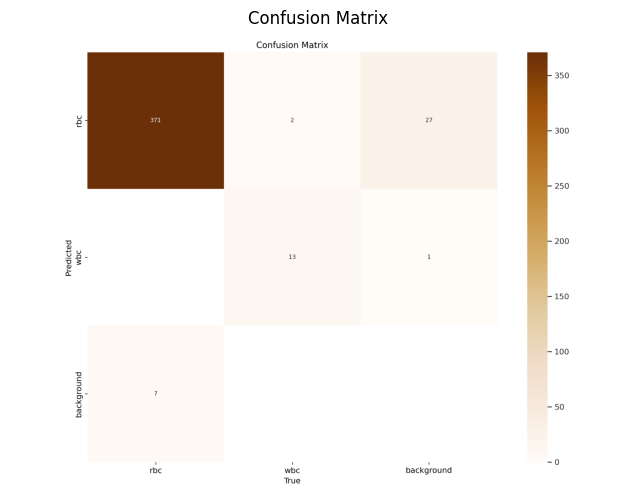

In [35]:
cm_path="/kaggle/working/runs/detect/train/confusion_matrix.png"
cm=cv2.imread(cm_path)
plt.figure(figsize=(8, 6))
plt.imshow(cm)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.axis('off')
plt.show()

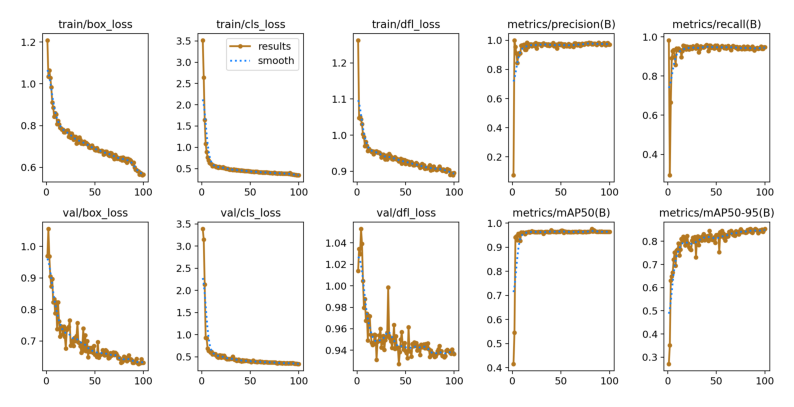

In [39]:
result_path="/kaggle/working/runs/detect/train/results.png"
res=cv2.imread(result_path)
plt.figure(figsize=(10,8))
plt.imshow(res)
plt.axis('off')
plt.show()

## Test Evaluation

In [40]:
test_result=model.val(data="/kaggle/working/yolo/cell_detection.yaml",split="test")

Ultralytics 8.3.78 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla T4, 15095MiB)
YOLOv12n summary (fused): 159 layers, 2,557,118 parameters, 0 gradients, 6.3 GFLOPs


val: Scanning /kaggle/working/yolo/labels/test... 20 images, 0 backgrounds, 0 corrupt: 100%|██████████| 20/20 [00:00<00:00, 722.47it/s]

val: New cache created: /kaggle/working/yolo/labels/test.cache



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.35it/s]


                   all         20        488      0.985      0.981      0.993      0.862
                   rbc         20        467      0.986      0.961      0.992      0.831
                   wbc         20         21      0.984          1      0.995      0.893


/usr/local/lib/python3.10/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.10/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


Speed: 0.9ms preprocess, 33.2ms inference, 0.0ms loss, 0.8ms postprocess per image
Results saved to runs/detect/train2


In [41]:
print(f"mAP50-95: {test_result.box.map:.2f}")  
print(f"mAP50: {test_result.box.map50:.2f}")    
print(f"Precision: {test_result.box.p:}")
print(f"Recall: {test_result.box.r:}")

mAP50-95: 0.86
mAP50: 0.99
Precision: [    0.98592     0.98384]
Recall: [    0.96146           1]


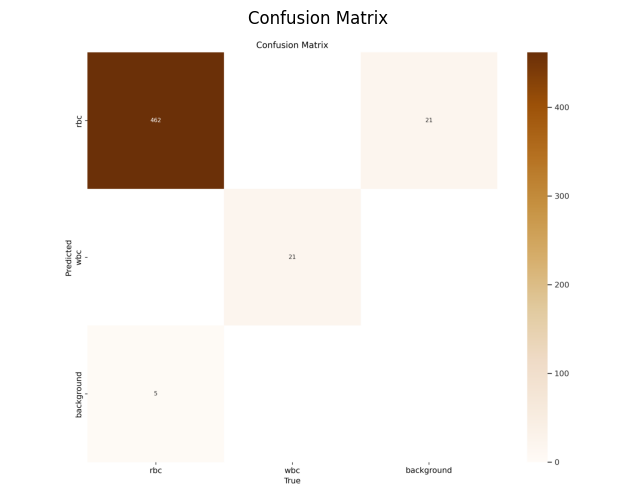

In [44]:
cm_path_test="/kaggle/working/runs/detect/train2/confusion_matrix.png"
cm_test=cv2.imread(cm_path_test)
plt.figure(figsize=(8, 6))
plt.imshow(cm_test)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.axis('off')
plt.show()


image 1/1 /kaggle/working/all/vimage-2.png: 256x256 21 rbcs, 1 wbc, 16.0ms
Speed: 0.9ms preprocess, 16.0ms inference, 1.4ms postprocess per image at shape (1, 3, 256, 256)


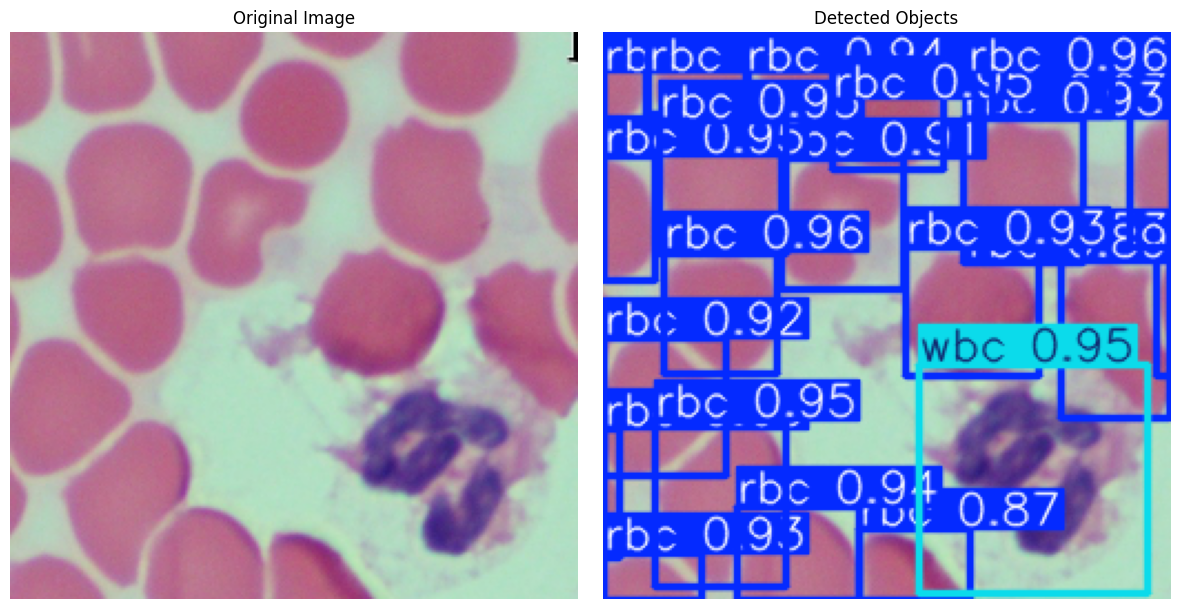


image 1/1 /kaggle/working/all/himage-14.png: 256x256 30 rbcs, 1 wbc, 14.7ms
Speed: 0.6ms preprocess, 14.7ms inference, 1.3ms postprocess per image at shape (1, 3, 256, 256)


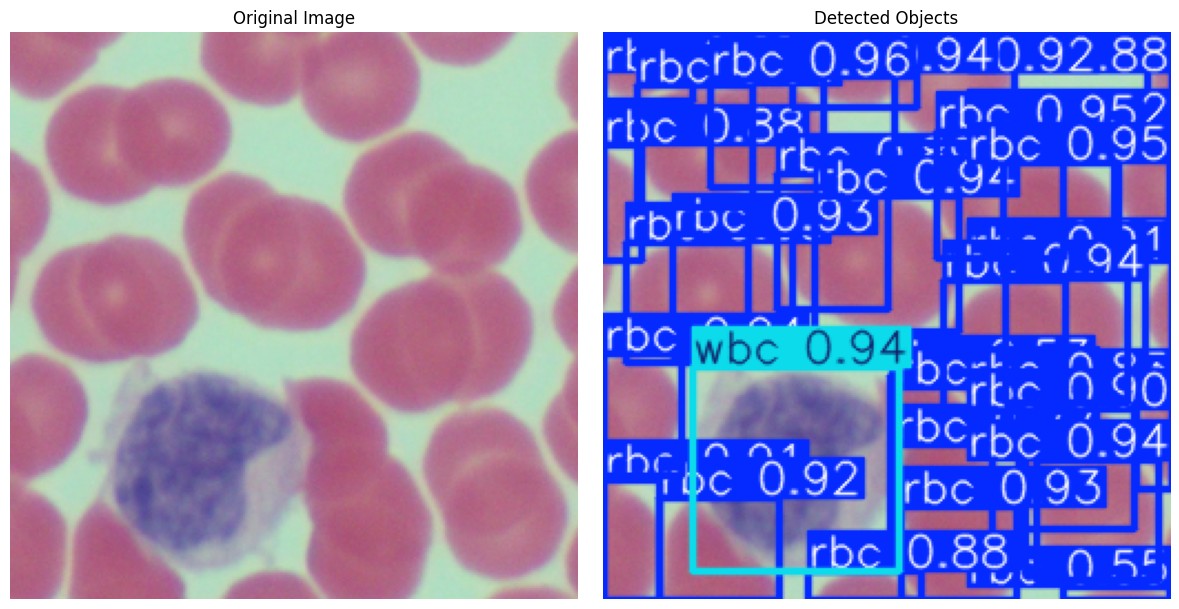


image 1/1 /kaggle/working/all/hrimage-90.png: 256x256 25 rbcs, 1 wbc, 12.2ms
Speed: 0.5ms preprocess, 12.2ms inference, 1.3ms postprocess per image at shape (1, 3, 256, 256)


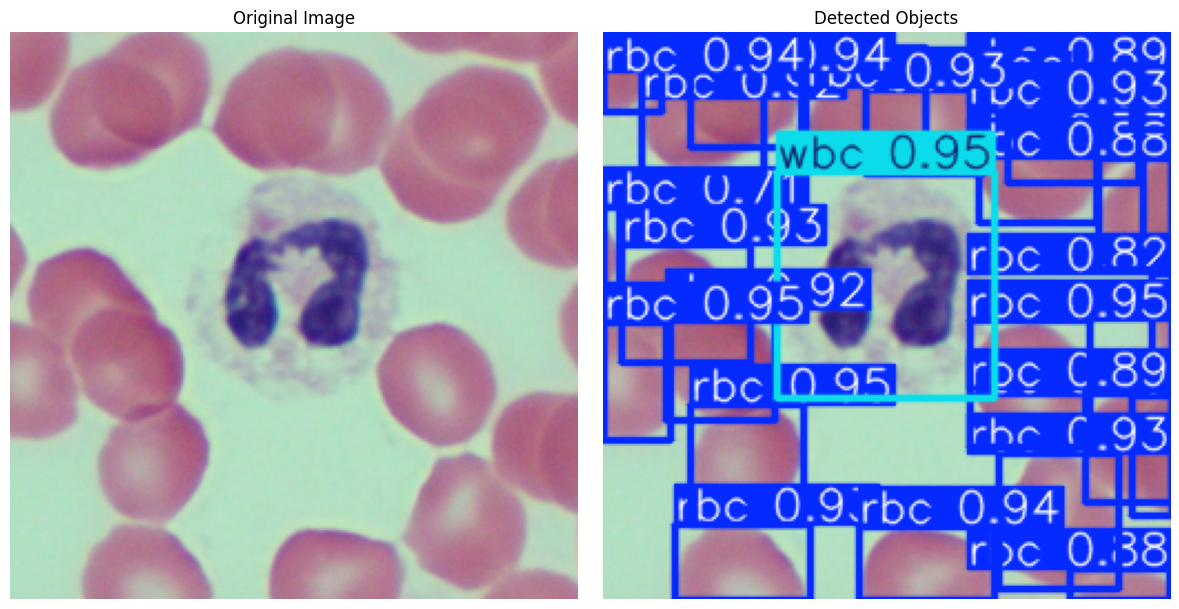


image 1/1 /kaggle/working/all/himage-80.png: 256x256 21 rbcs, 1 wbc, 13.1ms
Speed: 0.6ms preprocess, 13.1ms inference, 1.3ms postprocess per image at shape (1, 3, 256, 256)


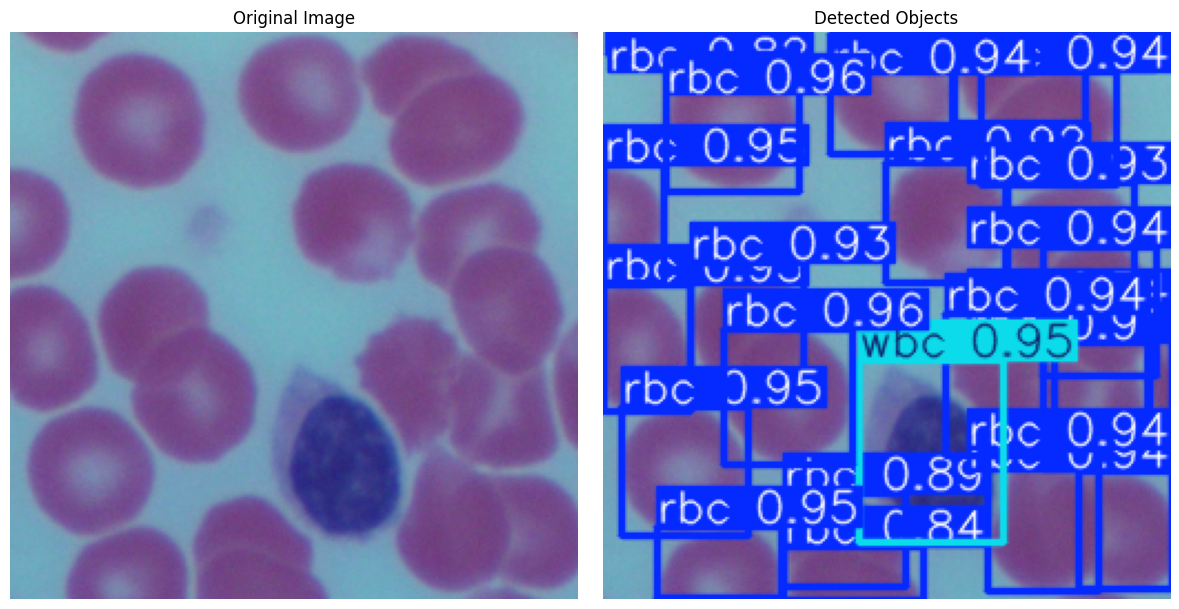


image 1/1 /kaggle/working/all/wimage-34.png: 256x256 1 wbc, 12.8ms
Speed: 0.5ms preprocess, 12.8ms inference, 2.6ms postprocess per image at shape (1, 3, 256, 256)


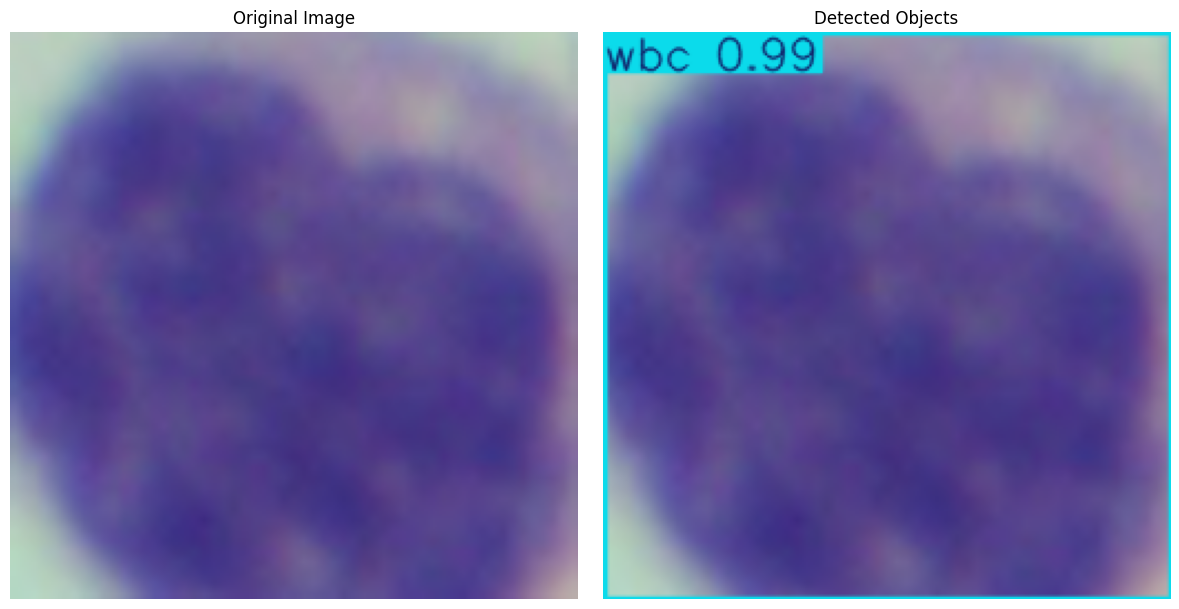

In [61]:
for i in range(5):
    img_name=random.choice(annotation.image.unique().tolist())
    img_path=os.path.join("/kaggle/working/all",img_name)
    img = cv2.imread(img_path)
    
    # Run detection with a confidence threshold of 0.5
    results = model.predict(img_path, conf=0.5)
    
    # The results object can draw the bounding boxes for you
    # .plot() returns an image with the predictions drawn on it (still in BGR format)
    annotated_img = results[0].plot()
    
    # Convert images from BGR to RGB for proper display with matplotlib
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    annotated_img_rgb = cv2.cvtColor(annotated_img, cv2.COLOR_BGR2RGB)
    
    # Display the original and annotated images side by side
    fig, axs = plt.subplots(1, 2, figsize=(12, 6))
    axs[0].imshow(img_rgb)
    axs[0].set_title("Original Image")
    axs[0].axis("off")
    
    axs[1].imshow(annotated_img_rgb)
    axs[1].set_title("Detected Objects")
    axs[1].axis("off")
    
    plt.tight_layout()
    plt.show()